In [46]:
import pandas as pd
import scipy.stats
import numpy as np
import os

from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

rc('text', usetex = True)

import warnings
warnings.filterwarnings('ignore')

os.chdir("/Users/acristia/Documents/Lucas/metrics/solomon-analysis")



# Problem

We have identified that 50 pairs of recordings out of 175 do not match. We aim to understand the reason for these mismatches. We also attempt to find a criterion to predict the integrity of a recording i.e. whether we can or cannot confidently assume it to be "complete". Some analysises might indeed require recordings without any gap, for instance when we need to label portions of audio with the time they were recorded at. A flag named `might_feature_gap` should be set to 1 when gaps are suspected/possible.

# Recordings duration

The distribution of the relative difference in audio durations among pairs of recordings is shown below. 60% of recordings have a relative duration difference above 10%. These differences are significant and common. Recordings could end prematurely but still be complete from start to end. Moreover, the distribution is mostly featureless. Therefore, it cannot be a good predictor of potentiel issues. Besides, this metric is not an intrinsic property of a recording, and cannot be generalised to experiments with no redundant records.

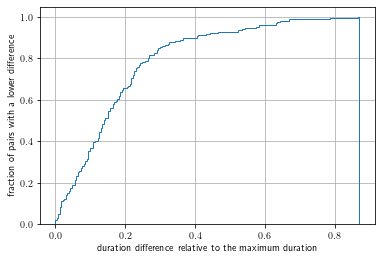

In [52]:
shifts = pd.read_csv('output/shifts.csv')
shifts.drop_duplicates(['filename_1', 'filename_2'], keep = 'first', inplace = True)
shifts['difference'] = shifts['duration_1']-shifts['duration_2']
shifts['difference'] = shifts['difference'].apply(abs)
shifts['max'] = shifts[['duration_1', 'duration_2']].max(axis = 1)

(shifts['difference']/shifts['max']).hist(cumulative = True, density = True, bins = 200, histtype = 'step')

plt.xlabel('duration difference relative to the maximum duration')
plt.ylabel('fraction of pairs with a lower difference')
plt.show()

# Merged recordings

Many recordings have undergone merges because they were originally split. We might expect that these recordings might have gaps, because the recorder could have stopped recording for any amount of time between two files. 

We plot the shift between audios among each pair (y-axis) against time (x-axis). Each subplot corresponds to a pair of recordings, with one point per hour. Pairs for which at least one recording is the result of merging several audio files are shown in red, the others in blue.

The standard deviation of shifts is also shown. When audios do not match, shift calculation is random and points are scattered with a high standard deviation. We consider that pairs with a standard deviation in shifts lower than 10 seconds are matching. Even for matching audios, it is expected that shift is not constant because of the recorders drift, which is of the order one 1 second per day.


<Figure size 432x288 with 0 Axes>

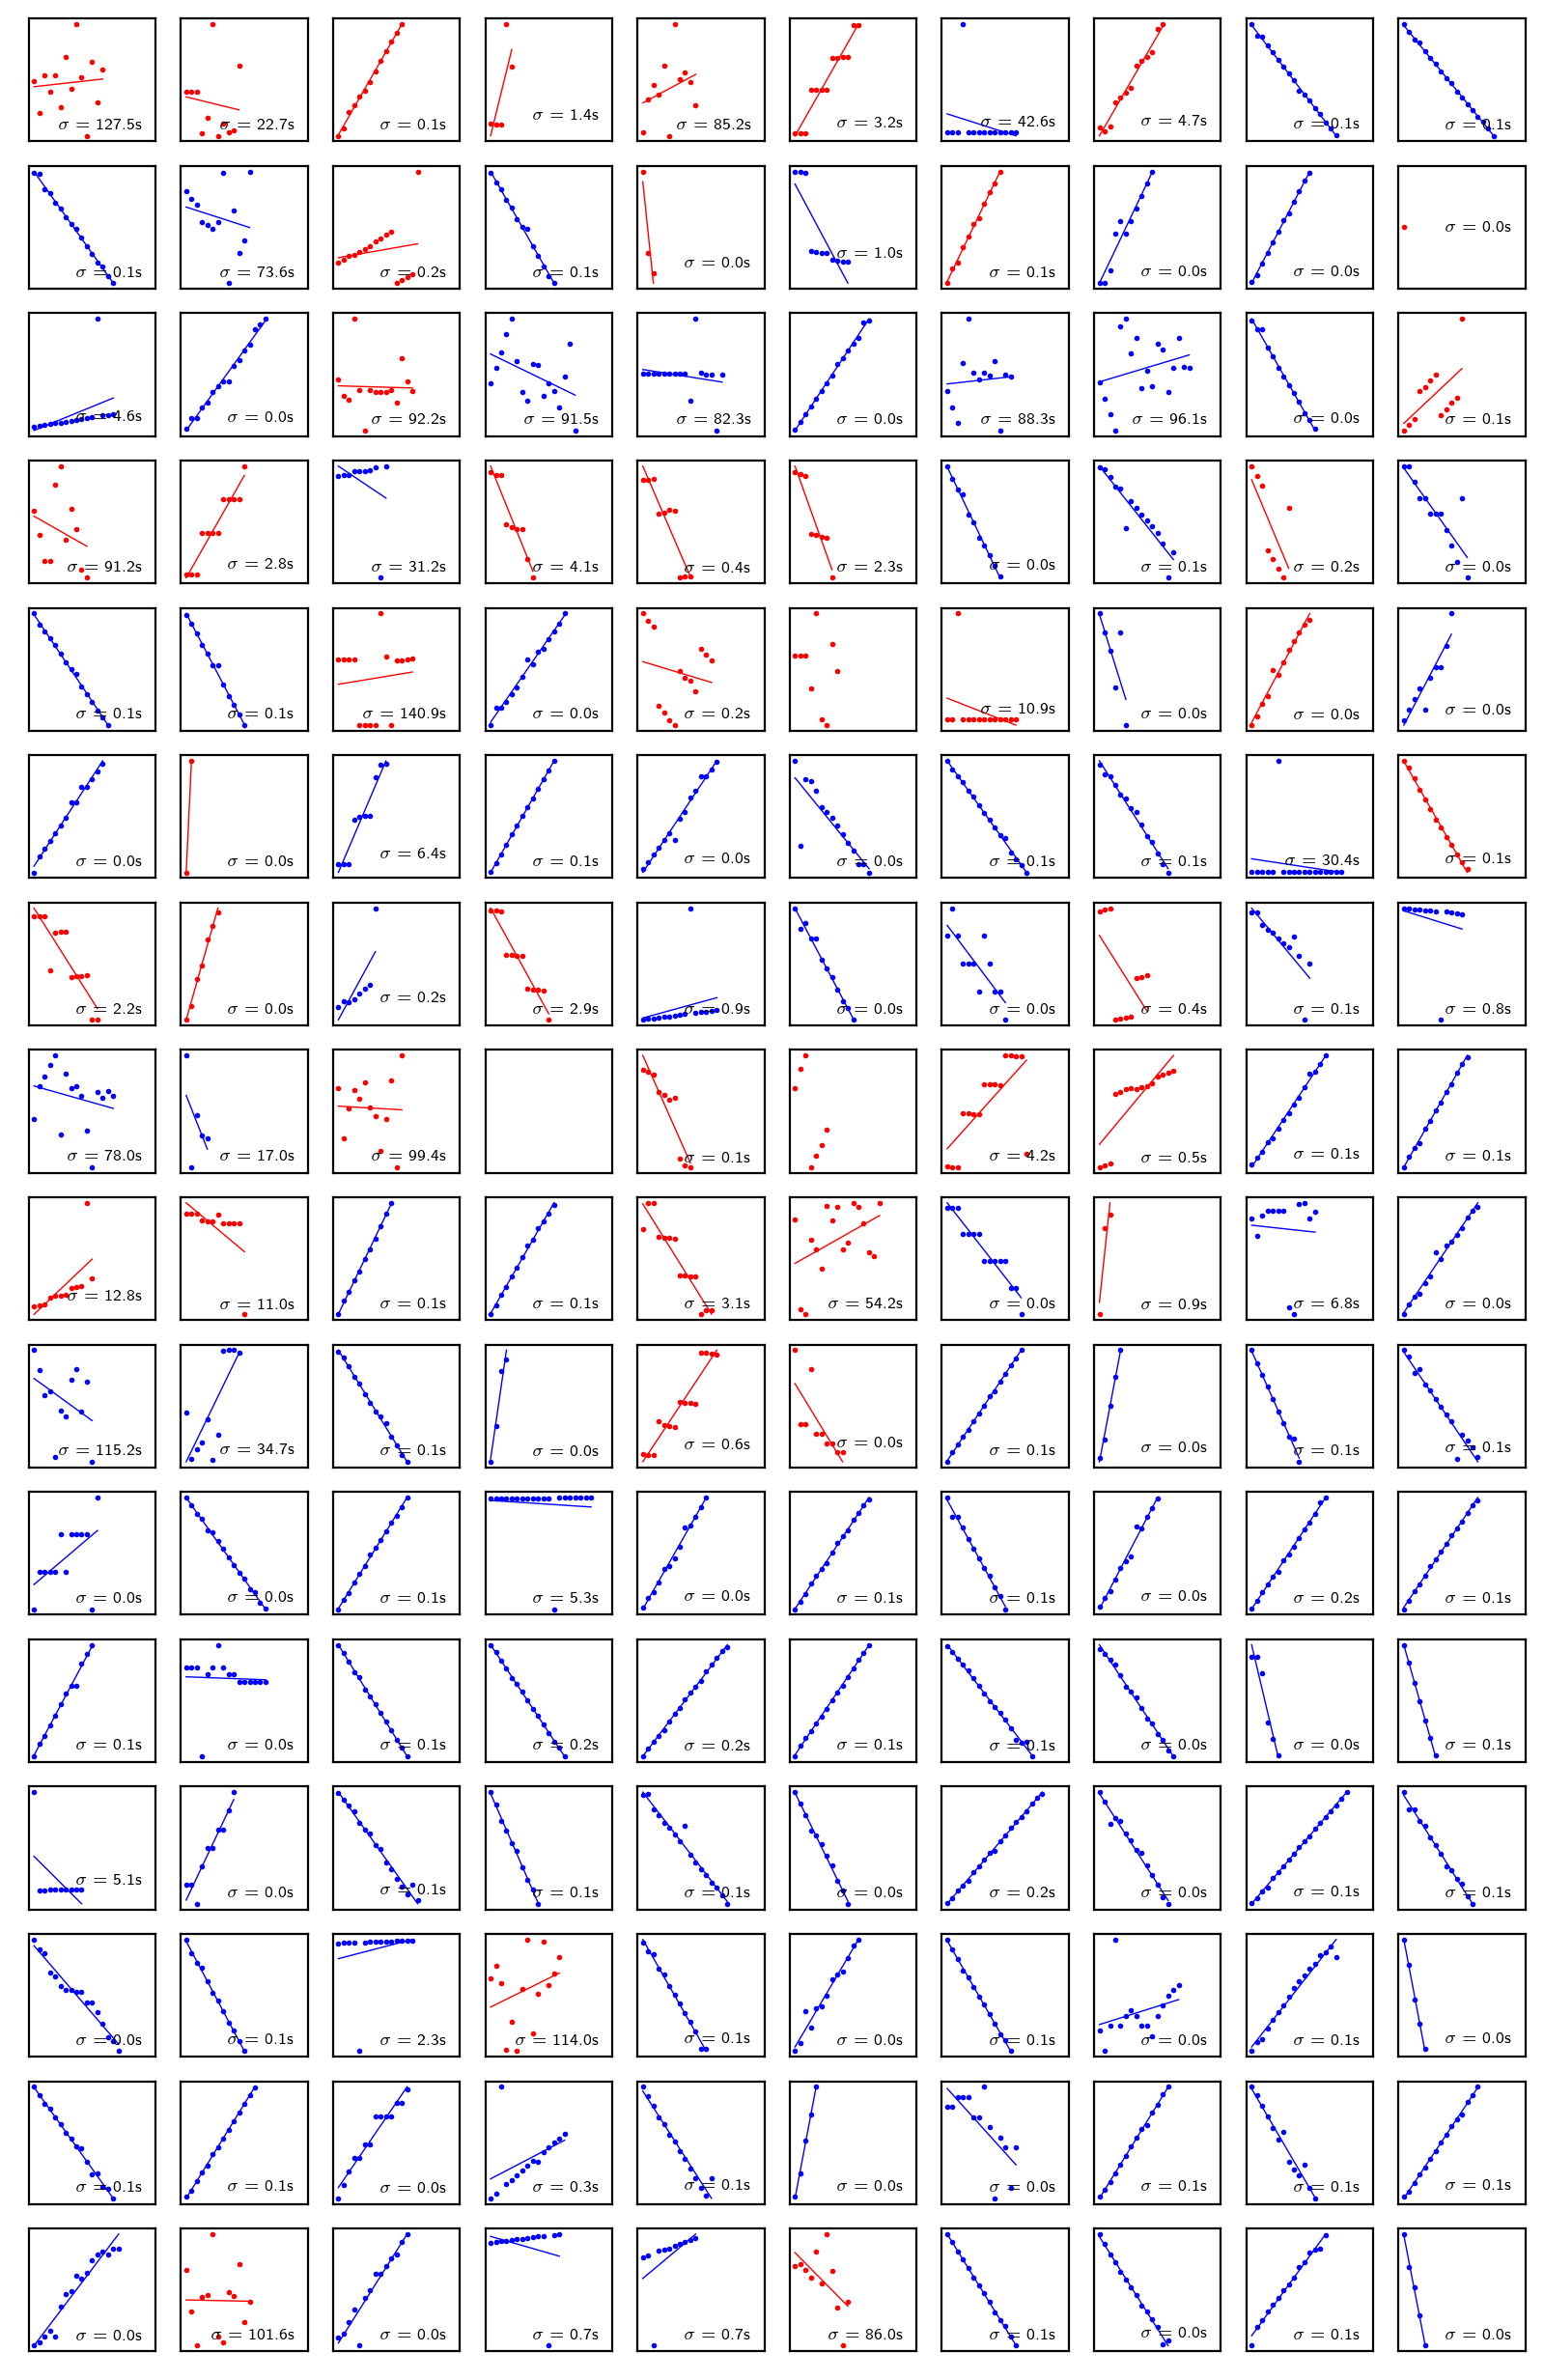

In [55]:
fig_rows = 16
fig_cols = 10

plt.clf()
plt.subplots(fig_rows, fig_cols, figsize = (fig_cols, fig_rows), dpi = 200)
plt.xlabel('time')
plt.ylabel('shift among pairs')

shifts = pd.read_csv('output/shifts.csv')
merged = pd.read_csv('solomon-data/metadata/merged.csv')
merged['recording'] = merged['filename'].str.extract(r"([0-9]+_(?:CW[0-9]+|NA)_CH[0-9]+_(?:AJ|FB|LM)[0-9]+_(?:AJ|FB|LM)[0-9]+_[0-9]{6})_") + '.WAV'
merged = merged.dropna()['recording'].tolist()

results = []
pos = 1
for pair, values in shifts.groupby(['filename_1', 'filename_2']):
    has_merges = pair[0] in merged or pair[1] in merged

    starts = values['start'].tolist()
    shifts = values['shift'].tolist()
    n = values['start'].shape[0]

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        starts,
        shifts
    )
    
    fit_y = [slope * x + intercept for x in starts]

    residuals = sum([
        (y - yf)**2
        for y, yf in zip(shifts, fit_y)
    ])

    rms = np.sqrt(residuals/n)

    results.append({
        'filename_1': pair[0],
        'filename_2': pair[1],
        'merges': has_merges,
        'rms': rms,
        'std': np.std(shifts),
        'gap': np.std(shifts) > 10
    })

    if pos <= fig_rows*fig_cols:
        plt.subplot(fig_rows, fig_cols, pos)
        plt.scatter(x = starts, y = shifts, s = 1, c = 'red' if has_merges else 'blue')
        plt.plot(starts, fit_y, linewidth = 0.5, c = 'red' if has_merges else 'blue')
        text_y = np.min(shifts) + (np.max(shifts)-np.min(shifts))*0.1
        if not np.isnan(text_y):
            plt.text(86400*0.9, text_y, "$\sigma =$ {:.1f}s".format(np.std(shifts)), va = 'center', ha = 'right', size = 6)
        plt.xlim(0, 86400)
        plt.xticks([])
        plt.yticks([])
        #if not np.isnan(p_value):
        #    plt.xlabel("rms = {:.3f}".format(rms), size = 6)

        pos += 1

results = pd.DataFrame(results)
plt.show()

We test further the potential of the variable "recording has merges" as a predictor of the presence of gaps by plotting the confusion matrix of these variables.

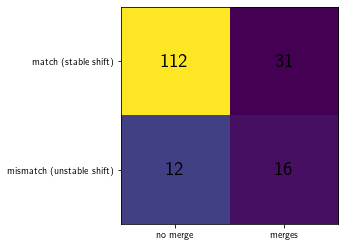

In [57]:
matrix = results.groupby(['merges', 'gap']).agg(count = ('std', len)).reset_index().pivot(index = 'merges', columns = 'gap').values
plt.clf()
plt.imshow(matrix)
for i in [0, 1]:
    for j in [0, 1]:
        plt.text(i, j, int(matrix[i][j]), va = 'center', ha = 'center', size = 20)

plt.xticks([0, 1], labels = ['no merge', 'merges'])
plt.yticks([0, 1], labels = ['match (stable shift)', 'mismatch (unstable shift)'])

plt.show()

Excluding audios that have undergone merges increases purity from 80,4 \% to 89,3 \%, but decreases exhaustivity from 100 \% to 78 \%.


Pros for labeling audios that have undergones merges as `might_feature_gaps`:

 - intrinsic property of a recording (no redundancy needed)
 - not arbitrary (no threshold, binary)

Cons:

 - approximate (many false positives)